In [7]:
import numpy as np
import cv2

from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

from utils import ones_state, state_ones

# board detector
import detector

Matplotlib is building the font cache; this may take a moment.


In [8]:
d = detector.Detector(64, 64, weights_path="weights-00-0.28.hdf5")

model created with # params: 507858
loading model weights from path: weights-00-0.28.hdf5
loaded weights


c:\Users\aabdo\miniconda3\envs\tic_tac_toe\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
def winner(state):
    state = np.reshape(state, [3,3])
    ones = np.ones(3)
    
    # check horizontal wins
    h = np.dot(ones, state)
    
    if np.any(h == 3):
        return 1
    elif np.any(h == -3):
        return -1
    
    # check vertical wins
    v = np.dot(state, ones)
    
    if np.any(v == 3):
        return 1
    elif np.any(v == -3):
        return -1
    
    # check diags
    dsum = np.sum(np.diag(state))
    if dsum == 3:
        return 1
    elif dsum == -3:
        return -1
    
    dsum = np.sum(np.diag(np.flipud(state)))
    if dsum == 3:
        return 1
    elif dsum == -3:
        return -1
    
    return 0

def draw(state):
    return not np.any(state==0)

def random_move(state):
    return np.random.choice(np.argwhere(state==0).flatten())

def random_game():
    state = np.zeros(9)
    states = [state.copy()]
    player = 1;
    while True:
        ri = random_move(state)
        state[ri] = player
        
        states.append(state.copy())
        
        w = winner(state)
        if w != 0:
            #print("winner")
            return w, states
        if draw(state):
            #print("draw")
            return 0, states
            
        player *= -1

k = {0: "- ", -1: "O ", 1: "X "}
def vis(state):
    s = ""
    for i in range(9):
        if i%3 == 0:
            s += "\n"
        s += k[state[i]]
        
    return s

[-1.  0. -1. -1.  0.  1.  1.  1.  1.]


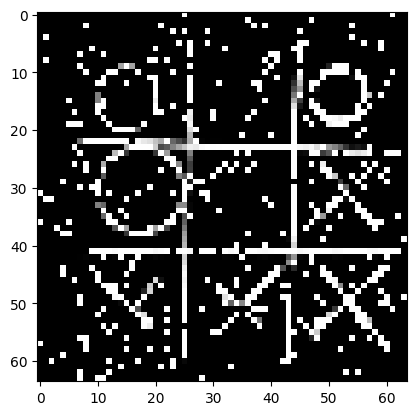

In [15]:
# data generation
gen_img_rows, gen_img_cols = 512, 512
low_rot = 2

def x_r():
    return np.random.randint(-16,16)

def rand_small_rot(img, sx, sy, s):
    rotation_matrix = cv2.getRotationMatrix2D((int(sx+s/2), int(sy+s/2)), np.random.randint(-low_rot,low_rot+1), 1)
    img = cv2.warpAffine(img, rotation_matrix, (gen_img_rows, gen_img_cols))
    return img

def img_from_state(state):
    
    img = np.zeros([gen_img_rows, gen_img_cols])
    s = 490 + np.random.randint(20)
    sx = np.random.randint(gen_img_cols-s)
    sy = np.random.randint(gen_img_rows-s)
    
    lw_lb = 6
    lw_ub = 12
    
    s_3 = int(s/3)
    s_x = int(s/10) + np.random.randint(10)
    s_o = int(s/24) + np.random.randint(30)
    
    # box
    #cv2.rectangle(img, (sx, sy), (sx+s, sy+s), 1, 1)

    # horizontal
    img = cv2.line(img, (sx, sy+s_3), (sx + s, sy+s_3), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    img = cv2.line(img, (sx, sy+s_3*2), (sx + s, sy+s_3*2), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    # vertical
    img = cv2.line(img, (sx+s_3, sy), (sx+s_3, sy+s), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    img = cv2.line(img, (sx+s_3*2, sy), (sx+s_3*2, sy+s), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    for i, s in enumerate(state):
        r = np.floor(i/3)
        c = i%3
        x = int(s_3/2 + sx + c * s_3)
        y = int(s_3/2 + sy + r * s_3)
        if s == 1:
            # draw x
            img = cv2.line(img, (x-s_x+x_r(), y-s_x+x_r()), (x+s_x+x_r(), y+s_x+x_r()), 1, np.random.randint(lw_lb, lw_ub))
            img = cv2.line(img, (x+s_x+x_r(), y-s_x+x_r()), (x-s_x+x_r(), y+s_x+x_r()), 1, np.random.randint(lw_lb, lw_ub))
            pass
        elif s == -1:
            #draw o
            img = cv2.circle(img, (x+x_r(), y+x_r()), np.random.randint(40,70), 1, np.random.randint(lw_lb, lw_ub))
            pass
    
    img_small = cv2.resize(img, (64-8, 64-8))
    
    img = np.zeros([64, 64])
    rr, rc = np.random.randint(0,8), np.random.randint(0,8)
    img[rr:rr+56,rc:rc+56] = img_small
    
    
    noise = np.random.randn(64,64)
    img[np.abs(noise)<.08] = 1
    img[np.abs(noise)>1.7] = 0
    return img

w, states = random_game()
vis(states[-1])
print(states[-1])
plt.imshow(img_from_state(states[-1]), cmap=plt.cm.gray)

In [5]:
# make some training data
x_train = []
y_train = []

for i in range(100000):
    if i % 1000 == 0:
        print('i: {}'.format(i))
    #w, ss = random_game()
    #s = ss[np.random.randint(len(ss))]
    s = np.random.randint(-1, 2, 9)
    img = img_from_state(s)
    
    x_train.append(img)
    y_train.append(state_ones(s))
    
x_train = np.array(x_train)
y_train = np.array(y_train)
    
plt.imshow(x_train[4], cmap=plt.cm.gray)
vis(ones_state(y_train[4]))

input_shape = None
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
num_outputs = y_train.shape[1]

i: 0


KeyboardInterrupt: 

In [310]:
# train

d.fit(x_train, y_train, epochs=1)

Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - 384s - loss: 0.0047 - acc: 0.3219 - val_loss: 0.0020 - val_acc: 0.2805


pred

- O - 
- X X 
O O - 


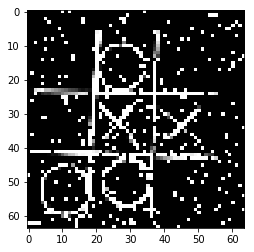

In [5]:
#w, states = random_game()
#ri = np.random.randint(len(states))
#state = states[ri]
state = np.random.randint(-1,2,9)
img = img_from_state(state)

fig = plt.imshow(img, cmap=plt.cm.gray)

print('pred')
pred = d.predict(img)
pred = np.round(pred)
vis(ones_state(pred))

array([ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0., -1.])

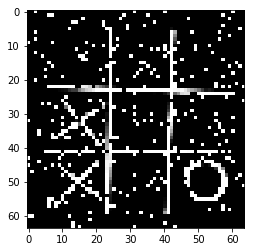

In [6]:
# take multiple samples to get the best identification
imgs = [img_from_state([0,0,0,1,0,0,1,0,-1]) for _ in range(10)]
plt.imshow(imgs[-1], cmap=plt.cm.gray)

pred = d.predict_average(imgs)
ones_state(pred)

In [6]:
import t3_ai
t3 = t3_ai.AI(weights_path="t3_weights-19-0.24.hdf5")

model created with # params: 353
loading model weights from path: t3_weights-19-0.24.hdf5
loaded weights


In [7]:
# realtime board detection
from time import sleep

def run_camera():
    cam = cv2.VideoCapture(0)
    k = 10
    last_k = []
    
    while True:
        ret_val, img = cam.read()
        #print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4)))
        
        img = cv2.flip(img, 1)
        img = img[0:d.img_rows, 0:d.img_cols]
        
        
        # adaptive thresholding
        # http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 15)
        img = 255-img
        img = img.astype(np.float64)
        img /= 255
        
        
        last_k.append(img)
        
        if len(last_k) >= k:
            clear_output(wait=True)
            #print('pred: ')
            state = ones_state(np.round(d.predict_average(last_k)))
            state = np.reshape(state, (1,9))
            val = t3.model.predict(state)[0,0]
            s = vis(ones_state(np.round(d.predict_average(last_k))))
            print("{} {}".format(s, val))
            
            last_k = last_k[1:]
            cv2.imshow('board_detector', cv2.resize(img, (512, 512)))

        
        
        if cv2.waitKey(1) == 27:
            break  # esc to quit
            
            
    cv2.destroyAllWindows()

run_camera()

KeyboardInterrupt: 